In [127]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, log_loss
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV


from keras.utils import to_categorical
import keras
import xgboost as xgb
from tensorflow.keras import layers

In [ ]:
tf.__version__

'2.15.0'

# Merging the 4 csv files

In [2]:
dfs = []

for i in range(1,5):
    path = 'UNSW-NB15_{}.csv' #There are 4 input csv files
    dfs.append(pd.read_csv(path.format(i), header = None))
combined_data = pd.concat(dfs).reset_index(drop=True) #Concat all to a single df

Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.


In [3]:
combined_data.head()

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,...,0,3,7,1,3,1,1,1,NaN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,NaN,0


In [4]:
dataset_columns = pd.read_csv('NUSW-NB15_features.csv', encoding = 'ISO-8859-1')
dataset_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   No.          49 non-null     int64 
 1   Name         49 non-null     object
 2   Type         49 non-null     object
 3   Description  49 non-null     object
dtypes: int64(1), object(3)
memory usage: 1.7+ KB


In [5]:
dataset_columns.head()

,No.,Name,Type,Description
0,1,srcip,nominal,Source IP address
1,2,sport,integer,Source port number
2,3,dstip,nominal,Destination IP address
3,4,dsport,integer,Destination port number
4,5,proto,nominal,Transaction protocol


# Adding Features names to the Combined_Data

In [6]:
combined_data.columns = dataset_columns['Name']
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2540047 entries, 0 to 2540046
Data columns (total 49 columns):
 #   Column            Dtype  
---  ------            -----  
 0   srcip             object 
 1   sport             object 
 2   dstip             object 
 3   dsport            object 
 4   proto             object 
 5   state             object 
 6   dur               float64
 7   sbytes            int64  
 8   dbytes            int64  
 9   sttl              int64  
 10  dttl              int64  
 11  sloss             int64  
 12  dloss             int64  
 13  service           object 
 14  Sload             float64
 15  Dload             float64
 16  Spkts             int64  
 17  Dpkts             int64  
 18  swin              int64  
 19  dwin              int64  
 20  stcpb             int64  
 21  dtcpb             int64  
 22  smeansz           int64  
 23  dmeansz           int64  
 24  trans_depth       int64  
 25  res_bdy_len       int64  
 26  Sjit          

In [7]:
combined_data.head()

Name,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,...,0,3,7,1,3,1,1,1,NaN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,NaN,0


# Data Cleaning

In [8]:
combined_data['Label'].value_counts()

Label
0    2218764
1     321283
Name: count, dtype: int64

In [9]:
combined_data['attack_cat'].isnull().sum()

2218764

In [10]:
# changing NaN (not a number) values in attack category to normal for standardizing the dataset.
# So, Absent value in attack category will be considered as normal behaviour ie no attack or anomaly.
#also turn all values to lowercase adn remove any white space from every string

combined_data['attack_cat'] = combined_data['attack_cat'].fillna(value='normal').apply(lambda x: x.strip().lower())

In [11]:
combined_data['attack_cat'].value_counts()

attack_cat
normal            2218764
generic            215481
exploits            44525
fuzzers             24246
dos                 16353
reconnaissance      13987
analysis             2677
backdoor             1795
shellcode            1511
backdoors             534
worms                 174
Name: count, dtype: int64

In [12]:
# backdoor and backdoors refers to the same thing. So changing all "backdoors" to "backdoor"
## Additionally, remvoe any white spaces and change everythign to lowercase

combined_data['attack_cat'] = combined_data['attack_cat'].replace('backdoors','backdoor', regex=True).apply(lambda x: x.strip().lower())

In [13]:
combined_data['attack_cat'].value_counts()

attack_cat
normal            2218764
generic            215481
exploits            44525
fuzzers             24246
dos                 16353
reconnaissance      13987
analysis             2677
backdoor             2329
shellcode            1511
worms                 174
Name: count, dtype: int64

In [14]:
# checking what columns have null values
combined_data.isnull().sum()

Name
srcip                     0
sport                     0
dstip                     0
dsport                    0
proto                     0
state                     0
dur                       0
sbytes                    0
dbytes                    0
sttl                      0
dttl                      0
sloss                     0
dloss                     0
service                   0
Sload                     0
Dload                     0
Spkts                     0
Dpkts                     0
swin                      0
dwin                      0
stcpb                     0
dtcpb                     0
smeansz                   0
dmeansz                   0
trans_depth               0
res_bdy_len               0
Sjit                      0
Djit                      0
Stime                     0
Ltime                     0
Sintpkt                   0
Dintpkt                   0
tcprtt                    0
synack                    0
ackdat                    0
is_sm_ips_ports

In [15]:
## ct_flw_http_mthd and is_ftp_login have null values that we need to change to 0

combined_data['ct_flw_http_mthd'] = combined_data['ct_flw_http_mthd'].fillna(value=0)
combined_data['is_ftp_login'] = combined_data['is_ftp_login'].fillna(value=0)

In [16]:
combined_data['ct_flw_http_mthd'].value_counts()

ct_flw_http_mthd
0.0     2334936
1.0      188008
6.0        7902
4.0        6564
3.0         738
2.0         588
5.0         430
9.0         270
14.0        224
12.0        132
30.0         60
8.0          56
16.0         48
36.0         36
10.0         30
25.0         25
Name: count, dtype: int64

In [17]:
combined_data['is_ftp_login'].value_counts()

is_ftp_login
0.0    2496472
1.0      43389
4.0        156
2.0         30
Name: count, dtype: int64

In [18]:
combined_data['is_ftp_login'] = np.where(combined_data['is_ftp_login']>1, 1, combined_data['is_ftp_login'])

In [19]:
combined_data['is_ftp_login'].value_counts()

is_ftp_login
0.0    2496472
1.0      43575
Name: count, dtype: int64

In [20]:
combined_data['service'].value_counts()

service
-           1246397
dns          781668
http         206273
ftp-data     125783
smtp          81645
ftp           49090
ssh           47160
pop3           1533
dhcp            172
ssl             142
snmp            113
radius           40
irc              31
Name: count, dtype: int64

In [21]:
combined_data['ct_ftp_cmd'].unique()

array([0, 1, 6, 2, 4, 8, 5, 3, '0', '1', ' ', '2', '4'], dtype=object)

In [22]:
#combined_data['ct_ftp_cmd'] = combined_data['ct_ftp_cmd'].replace(to_replace=' ', value=0).astype(int)
combined_data['ct_ftp_cmd'] = pd.to_numeric(combined_data['ct_ftp_cmd'].replace(' ', '0'), errors='coerce').fillna(0).astype(int)

In [23]:
combined_data['ct_ftp_cmd'].unique()

array([0, 1, 6, 2, 4, 8, 5, 3])

In [24]:
combined_data[['service','ct_flw_http_mthd','is_ftp_login','ct_ftp_cmd','attack_cat','Label']]

Name,service,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,attack_cat,Label
0,dns,0.0,0.0,0,normal,0
1,-,0.0,0.0,0,normal,0
2,dns,0.0,0.0,0,normal,0
3,dns,0.0,0.0,0,normal,0
4,dns,0.0,0.0,0,normal,0
...,...,...,...,...,...,...
2540042,ftp-data,0.0,0.0,0,normal,0
2540043,ftp,0.0,1.0,2,normal,0
2540044,ftp,0.0,1.0,2,normal,0
2540045,http,2.0,0.0,0,normal,0


In [25]:
combined_data['attack_cat'].nunique()

10

In [26]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2540047 entries, 0 to 2540046
Data columns (total 49 columns):
 #   Column            Dtype  
---  ------            -----  
 0   srcip             object 
 1   sport             object 
 2   dstip             object 
 3   dsport            object 
 4   proto             object 
 5   state             object 
 6   dur               float64
 7   sbytes            int64  
 8   dbytes            int64  
 9   sttl              int64  
 10  dttl              int64  
 11  sloss             int64  
 12  dloss             int64  
 13  service           object 
 14  Sload             float64
 15  Dload             float64
 16  Spkts             int64  
 17  Dpkts             int64  
 18  swin              int64  
 19  dwin              int64  
 20  stcpb             int64  
 21  dtcpb             int64  
 22  smeansz           int64  
 23  dmeansz           int64  
 24  trans_depth       int64  
 25  res_bdy_len       int64  
 26  Sjit          

In [27]:
combined_data.shape

(2540047, 49)

In [28]:
combined_data.drop(columns=['srcip','sport','dstip','dsport','Label'],inplace=True)

In [29]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2540047 entries, 0 to 2540046
Data columns (total 44 columns):
 #   Column            Dtype  
---  ------            -----  
 0   proto             object 
 1   state             object 
 2   dur               float64
 3   sbytes            int64  
 4   dbytes            int64  
 5   sttl              int64  
 6   dttl              int64  
 7   sloss             int64  
 8   dloss             int64  
 9   service           object 
 10  Sload             float64
 11  Dload             float64
 12  Spkts             int64  
 13  Dpkts             int64  
 14  swin              int64  
 15  dwin              int64  
 16  stcpb             int64  
 17  dtcpb             int64  
 18  smeansz           int64  
 19  dmeansz           int64  
 20  trans_depth       int64  
 21  res_bdy_len       int64  
 22  Sjit              float64
 23  Djit              float64
 24  Stime             int64  
 25  Ltime             int64  
 26  Sintpkt       

In [30]:
combined_data.shape

(2540047, 44)

In [31]:
#random sampling cause we have over 254m data
combined_data = combined_data.sample(frac=0.2, random_state=42)

In [32]:
combined_data.shape

(508009, 44)

In [33]:
combined_data['attack_cat'].value_counts()

attack_cat
normal            443831
generic            43109
exploits            8732
fuzzers             4784
dos                 3315
reconnaissance      2850
analysis             550
backdoor             477
shellcode            320
worms                 41
Name: count, dtype: int64

In [34]:
train, test = train_test_split(combined_data,test_size=0.2,random_state=16)
train, val = train_test_split(train,test_size=0.2,random_state=16)

In [35]:
train.shape

(325125, 44)

In [36]:
test.shape

(101602, 44)

In [78]:
x_train, y_train = train.drop(columns=['attack_cat']), train['attack_cat']
x_test, y_test = test.drop(columns=['attack_cat']), test['attack_cat']
x_val, y_val = val.drop(columns=['attack_cat']), val['attack_cat']

In [38]:
x_train.shape, y_train.shape

((325125, 43), (325125,))

In [39]:
x_test.shape, y_test.shape

((101602, 43), (101602,))

In [40]:
x_val.shape, y_val.shape

((81282, 43), (81282,))

In [41]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 325125 entries, 240402 to 739592
Data columns (total 44 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   proto             325125 non-null  object 
 1   state             325125 non-null  object 
 2   dur               325125 non-null  float64
 3   sbytes            325125 non-null  int64  
 4   dbytes            325125 non-null  int64  
 5   sttl              325125 non-null  int64  
 6   dttl              325125 non-null  int64  
 7   sloss             325125 non-null  int64  
 8   dloss             325125 non-null  int64  
 9   service           325125 non-null  object 
 10  Sload             325125 non-null  float64
 11  Dload             325125 non-null  float64
 12  Spkts             325125 non-null  int64  
 13  Dpkts             325125 non-null  int64  
 14  swin              325125 non-null  int64  
 15  dwin              325125 non-null  int64  
 16  stcpb             32

In [79]:
cat_col = ['proto', 'service', 'state']
num_col = list(set(x_train.columns) - set(cat_col))

In [80]:
train.head(10)

Name,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,...,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat
240402,tcp,FIN,0.822009,7798,16634,31,29,30,32,-,...,0.0,0,7,7,2,4,1,1,1,normal
1124875,tcp,FIN,0.733818,424,8824,31,29,1,4,ftp-data,...,0.0,0,3,3,3,1,1,1,5,normal
651672,tcp,FIN,0.301376,13038,548216,31,29,21,197,-,...,0.0,0,9,12,3,2,1,1,1,normal
1506280,tcp,FIN,0.013331,2334,16734,31,29,7,12,-,...,0.0,0,11,1,2,12,1,1,1,normal
2310637,tcp,FIN,1.006723,1580,10168,31,29,3,5,http,...,0.0,0,1,2,3,6,1,1,3,normal
1251720,tcp,FIN,0.005463,2054,2478,31,29,6,6,-,...,0.0,0,7,8,2,3,1,1,1,normal
2478883,tcp,FIN,0.223499,424,8824,31,29,1,4,ftp-data,...,0.0,0,3,5,7,4,1,1,4,normal
1888151,tcp,FIN,0.044935,2438,20576,31,29,7,13,-,...,0.0,0,1,1,1,2,1,1,1,normal
596845,tcp,FIN,1.136075,1684,10168,31,29,3,5,http,...,0.0,0,2,1,5,2,2,1,1,normal
959963,tcp,FIN,1.009212,1684,10168,31,29,3,5,http,...,0.0,0,1,1,1,1,1,1,1,normal


In [44]:
test.head(10)

Name,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,...,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat
2483603,udp,INT,0.000001,264,0,60,0,0,0,dns,...,0.0,0,45,45,37,37,37,18,45,normal
1508209,udp,INT,0.000003,264,0,60,0,0,0,dns,...,0.0,0,45,45,25,25,25,25,45,normal
619224,ospf,REQ,0.000000,384,0,1,0,0,0,-,...,0.0,0,2,4,4,2,2,4,2,normal
2392443,tcp,FIN,0.021624,37446,3380,31,29,18,8,smtp,...,0.0,0,2,2,3,3,1,1,3,normal
1065119,udp,CON,0.001835,520,304,31,29,0,0,-,...,0.0,0,7,6,3,5,1,1,3,normal
2530847,tcp,FIN,1.259989,7818,14922,31,29,30,32,-,...,0.0,0,17,1,1,13,1,1,1,normal
644854,tcp,FIN,1.139248,6250,207204,31,29,11,77,-,...,0.0,0,9,8,2,4,2,1,2,normal
210552,udp,CON,0.001048,132,164,31,29,0,0,dns,...,0.0,0,4,3,2,8,1,1,1,normal
12913,tcp,FIN,0.287848,4160,2976,31,29,7,7,-,...,0.0,0,10,6,1,9,1,1,1,normal
1713685,udp,INT,0.000009,114,0,254,0,0,0,dns,...,0.0,0,37,37,32,32,32,19,37,generic


# **Data Correlation**

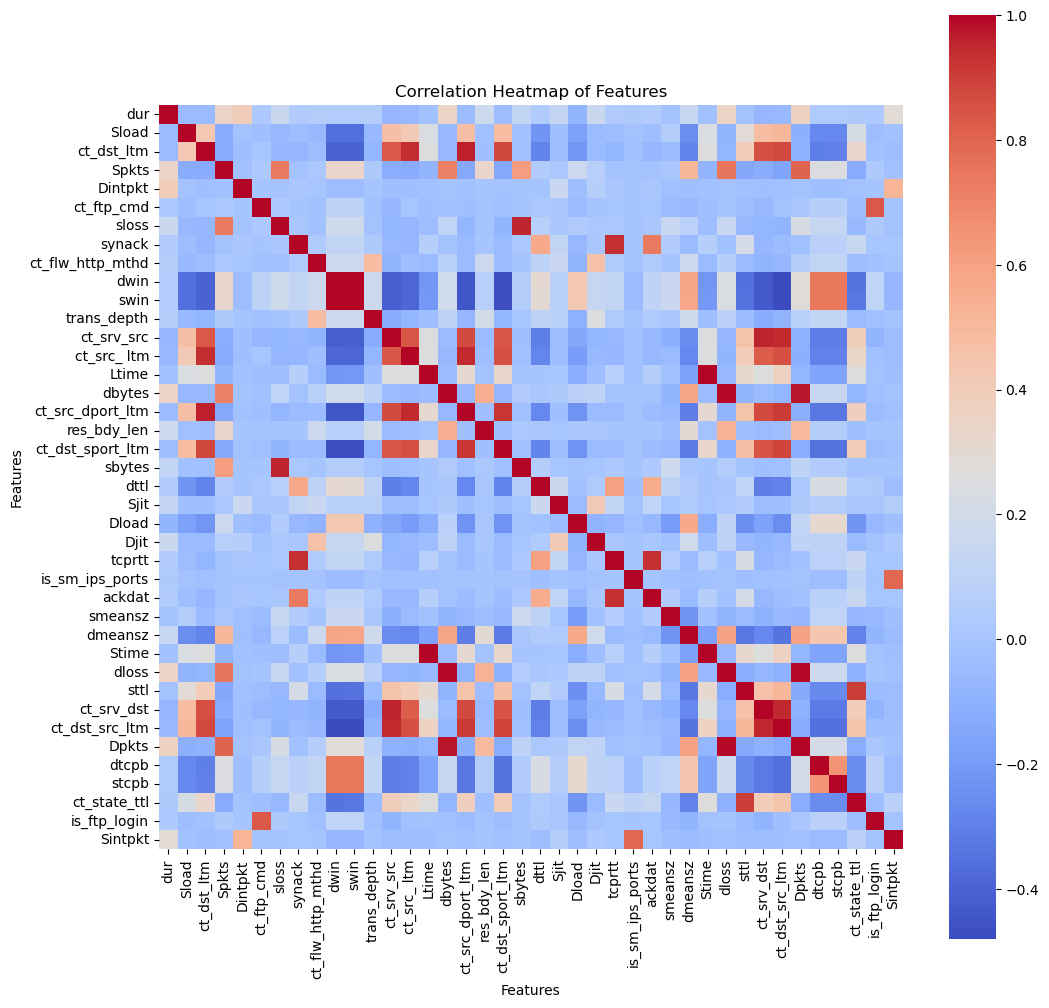

In [45]:
correlation_matrix = train[num_col].corr()

plt.figure(figsize=(12, 12))


sns.heatmap(correlation_matrix, cmap='coolwarm', square=True)

# Add labels and title
plt.xlabel('Features')
plt.ylabel('Features')
plt.title('Correlation Heatmap of Features')

# Rotate x-axis labels for better readability with many features
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Show the plot
plt.show()

In [46]:
train

Name,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,...,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat
240402,tcp,FIN,0.822009,7798,16634,31,29,30,32,-,...,0.0,0,7,7,2,4,1,1,1,normal
1124875,tcp,FIN,0.733818,424,8824,31,29,1,4,ftp-data,...,0.0,0,3,3,3,1,1,1,5,normal
651672,tcp,FIN,0.301376,13038,548216,31,29,21,197,-,...,0.0,0,9,12,3,2,1,1,1,normal
1506280,tcp,FIN,0.013331,2334,16734,31,29,7,12,-,...,0.0,0,11,1,2,12,1,1,1,normal
2310637,tcp,FIN,1.006723,1580,10168,31,29,3,5,http,...,0.0,0,1,2,3,6,1,1,3,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2261416,udp,INT,0.000002,264,0,60,0,0,0,dns,...,0.0,0,19,19,19,19,19,19,19,normal
2492225,udp,INT,0.000009,114,0,254,0,0,0,dns,...,0.0,0,9,9,10,9,9,9,9,generic
71589,tcp,FIN,0.014735,1540,1644,31,29,4,4,-,...,0.0,0,10,11,5,6,4,1,4,normal
107895,udp,CON,59.823212,100480,121106,254,60,0,0,-,...,0.0,0,3,3,3,3,3,3,3,dos


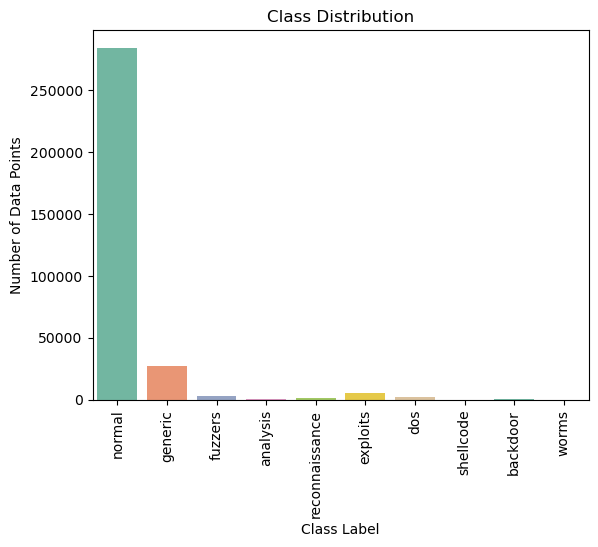

In [47]:
labels = train['attack_cat']

sns.countplot(x=labels, palette='Set2')

plt.xlabel('Class Label')
plt.ylabel('Number of Data Points')
plt.title('Class Distribution')

plt.xticks(rotation=90)

plt.show()

#**Data Preprocessing**



1.Data encoding : find the categorical features and use OneHotEncoder

2.Data Normalization : find numerical features and use StandardScaler

3.Feature Selection : SelectKBest


In [48]:
train

Name,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,...,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat
240402,tcp,FIN,0.822009,7798,16634,31,29,30,32,-,...,0.0,0,7,7,2,4,1,1,1,normal
1124875,tcp,FIN,0.733818,424,8824,31,29,1,4,ftp-data,...,0.0,0,3,3,3,1,1,1,5,normal
651672,tcp,FIN,0.301376,13038,548216,31,29,21,197,-,...,0.0,0,9,12,3,2,1,1,1,normal
1506280,tcp,FIN,0.013331,2334,16734,31,29,7,12,-,...,0.0,0,11,1,2,12,1,1,1,normal
2310637,tcp,FIN,1.006723,1580,10168,31,29,3,5,http,...,0.0,0,1,2,3,6,1,1,3,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2261416,udp,INT,0.000002,264,0,60,0,0,0,dns,...,0.0,0,19,19,19,19,19,19,19,normal
2492225,udp,INT,0.000009,114,0,254,0,0,0,dns,...,0.0,0,9,9,10,9,9,9,9,generic
71589,tcp,FIN,0.014735,1540,1644,31,29,4,4,-,...,0.0,0,10,11,5,6,4,1,4,normal
107895,udp,CON,59.823212,100480,121106,254,60,0,0,-,...,0.0,0,3,3,3,3,3,3,3,dos


In [49]:
test

Name,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,...,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat
2483603,udp,INT,0.000001,264,0,60,0,0,0,dns,...,0.0,0,45,45,37,37,37,18,45,normal
1508209,udp,INT,0.000003,264,0,60,0,0,0,dns,...,0.0,0,45,45,25,25,25,25,45,normal
619224,ospf,REQ,0.000000,384,0,1,0,0,0,-,...,0.0,0,2,4,4,2,2,4,2,normal
2392443,tcp,FIN,0.021624,37446,3380,31,29,18,8,smtp,...,0.0,0,2,2,3,3,1,1,3,normal
1065119,udp,CON,0.001835,520,304,31,29,0,0,-,...,0.0,0,7,6,3,5,1,1,3,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2072728,tcp,FIN,0.004783,3728,2456,31,29,7,7,-,...,0.0,0,7,7,5,4,1,1,4,normal
1355075,br-sat-mon,INT,0.000005,200,0,254,0,0,0,-,...,0.0,0,2,2,1,19,1,1,2,exploits
1766531,tcp,FIN,0.011821,2542,23122,31,29,7,14,-,...,0.0,0,2,4,2,2,1,1,2,normal
1068135,tcp,FIN,0.005422,8928,320,31,29,4,1,ftp-data,...,0.0,0,3,3,12,5,1,1,4,normal


In [81]:
scaler = StandardScaler()
scaler = scaler.fit(x_train[num_col])
x_train[num_col] = scaler.transform(x_train[num_col])
x_test[num_col] = scaler.transform(x_test[num_col])
x_val[num_col] = scaler.transform(x_val[num_col])

In [82]:
x_train.isnull().sum()

Name
proto               0
state               0
dur                 0
sbytes              0
dbytes              0
sttl                0
dttl                0
sloss               0
dloss               0
service             0
Sload               0
Dload               0
Spkts               0
Dpkts               0
swin                0
dwin                0
stcpb               0
dtcpb               0
smeansz             0
dmeansz             0
trans_depth         0
res_bdy_len         0
Sjit                0
Djit                0
Stime               0
Ltime               0
Sintpkt             0
Dintpkt             0
tcprtt              0
synack              0
ackdat              0
is_sm_ips_ports     0
ct_state_ttl        0
ct_flw_http_mthd    0
is_ftp_login        0
ct_ftp_cmd          0
ct_srv_src          0
ct_srv_dst          0
ct_dst_ltm          0
ct_src_ ltm         0
ct_src_dport_ltm    0
ct_dst_sport_ltm    0
ct_dst_src_ltm      0
dtype: int64

In [87]:
#Encode the features
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(sparse=False,handle_unknown='ignore'), cat_col)], remainder='passthrough')
x_train = np.array(ct.fit_transform(x_train))
x_test = np.array(ct.transform(x_test))
x_val = np.array(ct.transform(x_val))

In [92]:
y_train

240402      normal
1124875     normal
651672      normal
1506280     normal
2310637     normal
            ...   
2261416     normal
2492225    generic
71589       normal
107895         dos
739592      normal
Name: attack_cat, Length: 325125, dtype: object

In [93]:
label_encoder = LabelEncoder()

# Encode the labels
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)
y_val = label_encoder.fit_transform(y_val)

In [94]:
print(np.unique(y_train))

[0 1 2 3 4 5 6 7 8 9]


In [95]:
x_train.shape

(325125, 199)

# **TRAINING PROCESS- MACHINE LEARNING CLASSIFIERS**

In [96]:
param_grid_lr = {
    'C': [10**i for i in range(-10,10)],
}
# Create a GridSearchCV object
grid_search_lr = GridSearchCV(LogisticRegression(), param_grid_lr, cv=5)
grid_search_lr.fit(x_train, y_train)
# Get the best parameters from the grid search
best_params_lr = grid_search_lr.best_params_
print("Best Hyperparameters with Highest Accuracy Score:", best_params_lr)

best_model_lr = LogisticRegression(**best_params_lr)
best_model_lr.fit(x_train, y_train)
y_pred_lr = best_model_lr.predict(x_test)

DONE1
DONE2


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

DONE3
Best Hyperparameters with Highest Accuracy Score: {'C': 1000000000}
DONE4
DONE5
DONE6


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Accuracy: 97.28%
Recall: 97.28%
Precision: 97.01%
F1-Score: 97.00%


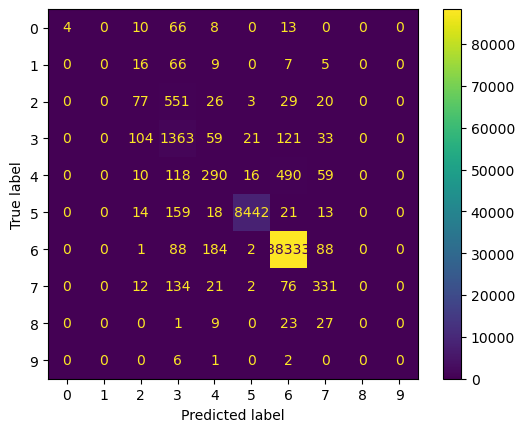

In [97]:
accuracy = accuracy_score(y_test, y_pred_lr)
recall = recall_score(y_test, y_pred_lr, average='weighted')
precision = precision_score(y_test, y_pred_lr, average='weighted')
f1s = f1_score(y_test, y_pred_lr, average='weighted')
cm = confusion_matrix(y_test, y_pred_lr)
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = best_model_lr.classes_).plot()

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))

In [98]:
param_grid_knn = {
    'n_neighbors': range(1, 50),
}
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5)
grid_search_knn.fit(x_train, y_train)

# Get the best parameters from the grid search for KNN
best_params_knn = grid_search_knn.best_params_
print("Best Hyperparameters for KNN with Highest Accuracy Score:", best_params_knn)

# Initialize the KNNClassifier with the best parameters
best_model_knn = KNeighborsClassifier(**best_params_knn)
best_model_knn.fit(x_train, y_train)
y_pred_knn = best_model_knn.predict(x_test)

Best Hyperparameters for KNN with Highest Accuracy Score: {'n_neighbors': 16}


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Accuracy: 97.19%
Recall: 97.19%
Precision: 97.00%
F1-Score: 97.07%


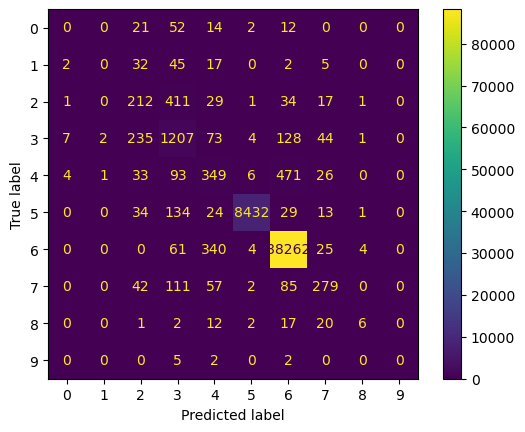

In [99]:
accuracy = accuracy_score(y_test, y_pred_knn)
recall = recall_score(y_test, y_pred_knn, average='weighted')
precision = precision_score(y_test, y_pred_knn, average='weighted')
f1s = f1_score(y_test, y_pred_knn, average='weighted')
cm = confusion_matrix(y_test, y_pred_knn)
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = best_model_knn.classes_).plot()

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))

In [100]:
param_grid_dt = {
    'max_depth': range(1, 50),
    'min_samples_leaf': range(1, 50),
}
# Create a GridSearchCV object
grid_search_dt = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=5)
grid_search_dt.fit(x_train, y_train)
# Get the best parameters from the grid search
best_params_dt = grid_search_dt.best_params_
print("Best Hyperparameters:", best_params_dt)

# Initialize the DecisionTreeClassifier with the best parameters
best_model_dt = DecisionTreeClassifier(**best_params_dt)
best_model_dt.fit(x_train, y_train)
# Make predictions on the test set
y_pred_dt = best_model_dt.predict(x_test)

DONE1
DONE2
DONE3
Best Hyperparameters: {'max_depth': 13, 'min_samples_leaf': 1}
DONE4
DONE5
DONE6


Accuracy: 97.77%
Recall: 97.77%
Precision: 97.53%
F1-Score: 97.54%


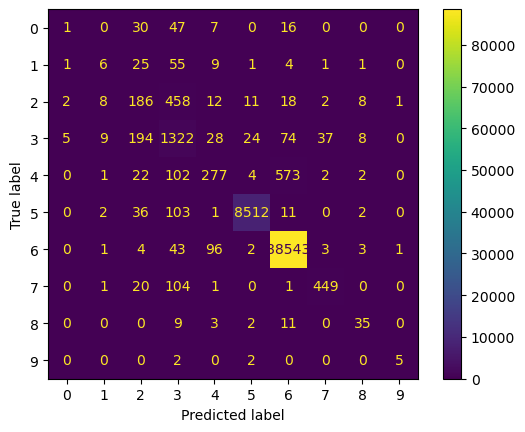

In [101]:
accuracy = accuracy_score(y_test, y_pred_dt)
recall = recall_score(y_test, y_pred_dt, average='weighted')
precision = precision_score(y_test, y_pred_dt, average='weighted')
f1s = f1_score(y_test, y_pred_dt, average='weighted')
cm = confusion_matrix(y_test, y_pred_dt)
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = best_model_dt.classes_).plot()

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))

In [102]:
param_grid_rf = {
    'n_estimators': [100, 200]
}

# Create a GridSearchCV object
grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5)
grid_search_rf.fit(x_train, y_train)

best_params_rf = grid_search_rf.best_params_
print("Best Hyperparameters for RF with Highest Accuracy Score:", best_params_rf)

best_model_rf = RandomForestClassifier(**best_params_rf, criterion= 'entropy')
best_model_rf.fit(x_train, y_train)
y_pred_rf = best_model_rf.predict(x_test)

Best Hyperparameters for RF with Highest Accuracy Score: {'n_estimators': 200}


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Accuracy: 97.81%
Recall: 97.81%
Precision: 97.68%
F1-Score: 97.72%


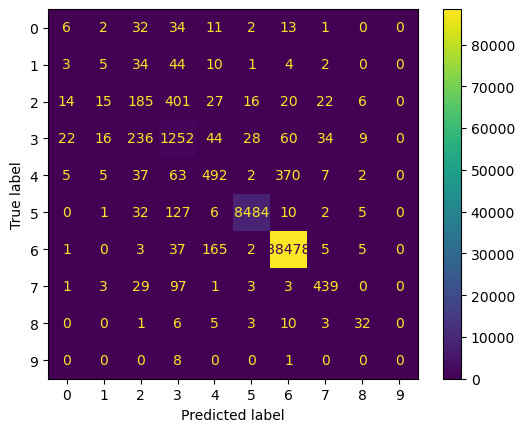

In [103]:
accuracy = accuracy_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf, average='weighted')
precision = precision_score(y_test, y_pred_rf, average='weighted')
f1s = f1_score(y_test, y_pred_rf, average='weighted')
cm = confusion_matrix(y_test, y_pred_rf)
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = best_model_rf.classes_).plot()

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))

In [106]:
param_grid_xg = {
    'n_estimators': [100, 200, 300]
}

grid_search_xg = GridSearchCV(xgb.XGBClassifier(), param_grid_xg, cv=5)
grid_search_xg.fit(x_train, y_train)
best_params_xg = grid_search_xg.best_params_
print("Best Hyperparameters with Highest Accuracy Score:", best_params_xg)

best_model_xg =  xgb.XGBClassifier(**best_params_xg)
best_model_xg.fit(x_train, y_train)
y_pred_xg = best_model_xg.predict(x_test)

DONE1
DONE2
Best Hyperparameters with Highest Accuracy Score: {'n_estimators': 100}
DONE3
DONE4


Accuracy: 98.02%
Recall: 98.02%
Precision: 97.92%
F1-Score: 97.91%


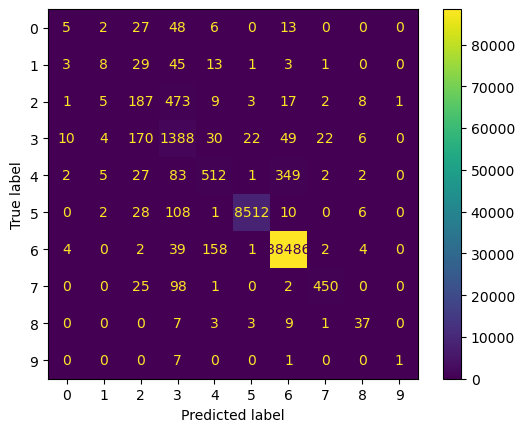

In [107]:
accuracy = accuracy_score(y_test, y_pred_xg)
recall = recall_score(y_test, y_pred_xg, average='weighted')
precision = precision_score(y_test, y_pred_xg, average='weighted')
f1s = f1_score(y_test, y_pred_xg, average='weighted')
cm = confusion_matrix(y_test, y_pred_xg)
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = best_model_xg.classes_).plot()

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))

In [74]:
# **TRAINING PROCESS- DEEP LEARNING**

In [121]:
x_train.shape

(325125, 199)

In [122]:
y_train.shape

(325125,)

In [123]:
y_train_categorical = to_categorical(y_train)
y_train_categorical.shape

(325125, 10)

In [124]:
y_val.shape

(81282,)

In [125]:
y_val_categorical = to_categorical(y_val)
y_val_categorical.shape

(81282, 10)

In [140]:
#model parameters
n_features = x_train.shape[1]  # Number of features from training data

model = keras.Sequential([
    layers.Input(shape=(n_features,1)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),  # batch normalization layer
    layers.Dropout(0.5),          # dropout layer
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),  
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [141]:
history = model.fit(x_train, y_train_categorical, epochs=20, batch_size=32,validation_data=(x_val,y_val_categorical))

Epoch 1/20
10161/10161 [==============================] - 27s 3ms/step - loss: 0.0992 - accuracy: 0.9653 - precision_6: 0.9894 - recall_6: 0.9516 - val_loss: 0.0703 - val_accuracy: 0.9732 - val_precision_6: 0.9946 - val_recall_6: 0.9563
Epoch 2/20
10161/10161 [==============================] - 25s 2ms/step - loss: 0.0767 - accuracy: 0.9710 - precision_6: 0.9906 - recall_6: 0.9578 - val_loss: 0.0704 - val_accuracy: 0.9733 - val_precision_6: 0.9876 - val_recall_6: 0.9637
Epoch 3/20
10161/10161 [==============================] - 26s 3ms/step - loss: 0.0732 - accuracy: 0.9720 - precision_6: 0.9902 - recall_6: 0.9595 - val_loss: 0.0655 - val_accuracy: 0.9744 - val_precision_6: 0.9931 - val_recall_6: 0.9606
Epoch 4/20
10161/10161 [==============================] - 25s 2ms/step - loss: 0.0715 - accuracy: 0.9724 - precision_6: 0.9900 - recall_6: 0.9601 - val_loss: 0.0653 - val_accuracy: 0.9729 - val_precision_6: 0.9893 - val_recall_6: 0.9640
Epoch 5/20
10161/10161 [============================

In [142]:
y_test_categorical = to_categorical(y_test)
y_test_categorical.shape

(101602, 10)

In [143]:
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(x_test, y_test_categorical)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)

3176/3176 [==============================] - 4s 1ms/step - loss: 0.0615 - accuracy: 0.9744 - precision_6: 0.9930 - recall_6: 0.9617
Test Loss: 0.06154867634177208
Test Accuracy: 0.9744493365287781
Test Precision: 0.9930078387260437
Test Recall: 0.9616739749908447


In [144]:
y_pred = model.predict(x_test)
y_pred

3176/3176 [==============================] - 3s 1ms/step


array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [2.4497646e-31, 0.0000000e+00, 1.6079915e-25, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.6865420e-34, 0.0000000e+00, 1.1471859e-34, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [3.1382561e-34, 0.0000000e+00, 9.2743722e-34, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [ ]:
#Using a learning rate of 0.005

In [145]:
model = keras.Sequential([
    layers.Input(shape=(n_features,1)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),  # batch normalization layer
    layers.Dropout(0.5),          # dropout layer
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(), 
    layers.Dropout(0.5),         
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [146]:
history = model.fit(x_train, y_train_categorical, epochs=20, batch_size=32,validation_data=(x_val,y_val_categorical))

Epoch 1/20
10161/10161 [==============================] - 29s 3ms/step - loss: 0.0990 - accuracy: 0.9658 - precision_7: 0.9901 - recall_7: 0.9513 - val_loss: 0.0793 - val_accuracy: 0.9697 - val_precision_7: 0.9928 - val_recall_7: 0.9572
Epoch 2/20
10161/10161 [==============================] - 26s 3ms/step - loss: 0.0866 - accuracy: 0.9687 - precision_7: 0.9911 - recall_7: 0.9553 - val_loss: 0.0787 - val_accuracy: 0.9702 - val_precision_7: 0.9942 - val_recall_7: 0.9559
Epoch 3/20
10161/10161 [==============================] - 25s 3ms/step - loss: 0.0837 - accuracy: 0.9691 - precision_7: 0.9916 - recall_7: 0.9560 - val_loss: 0.0844 - val_accuracy: 0.9702 - val_precision_7: 0.9891 - val_recall_7: 0.9607
Epoch 4/20
10161/10161 [==============================] - 26s 3ms/step - loss: 0.0831 - accuracy: 0.9696 - precision_7: 0.9911 - recall_7: 0.9565 - val_loss: 0.0730 - val_accuracy: 0.9719 - val_precision_7: 0.9908 - val_recall_7: 0.9601
Epoch 5/20
10161/10161 [============================

In [147]:
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(x_test, y_test_categorical)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)

3176/3176 [==============================] - 4s 1ms/step - loss: 0.0735 - accuracy: 0.9715 - precision_7: 0.9895 - recall_7: 0.9602
Test Loss: 0.07352432608604431
Test Accuracy: 0.9715458154678345
Test Precision: 0.9894825220108032
Test Recall: 0.9602271318435669
